In [1]:
from imutils import face_utils
from utils import *
import numpy as np
import pyautogui as pag
import imutils
import dlib
import cv2
import time

# Thresholds and consecutive frame length for triggering the mouse action.
MOUTH_AR_THRESH = 0.6
MOUTH_AR_CONSECUTIVE_FRAMES = 15
EYE_AR_THRESH = 0.19
EYE_AR_CONSECUTIVE_FRAMES = 15
WINK_AR_DIFF_THRESH = 0.04
WINK_AR_CLOSE_THRESH = 0.19
WINK_CONSECUTIVE_FRAMES = 10

# Initialize the frame counters for each action as well as 
# booleans used to indicate if action is performed or not
MOUTH_COUNTER = 0
EYE_COUNTER = 0
COUNTER = 0
TOTAL = 0
EB_COUNTER = 0
EB_TOTAL = 0
WINK_COUNTER = 0
INPUT_MODE = False
EYE_CLICK = False
LEFT_WINK = False
RIGHT_WINK = False
SCROLL_MODE = False
ANCHOR_POINT = (0, 0)
WHITE_COLOR = (255, 255, 255)
YELLOW_COLOR = (0, 255, 255)
RED_COLOR = (0, 0, 255)
GREEN_COLOR = (0, 255, 0)
BLUE_COLOR = (255, 0, 0)
BLACK_COLOR = (0, 0, 0)

#Lists to store timestamp and reaction
timestamp = []
emotions = []

# Initialize Dlib's face detector (HOG-based) and then create
# the facial landmark predictor
shape_predictor = "shape_predictor_68_face_landmarks.dat"
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor(shape_predictor)

# Grab the indexes of the facial landmarks for the left and
# right eye, nose and mouth respectively
(lStart, lEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eye"]
(rStart, rEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eye"]
(nStart, nEnd) = face_utils.FACIAL_LANDMARKS_IDXS["nose"]
(mStart, mEnd) = face_utils.FACIAL_LANDMARKS_IDXS["mouth"]
(leStart, leEnd) = face_utils.FACIAL_LANDMARKS_IDXS["left_eyebrow"]
(reStart, reEnd) = face_utils.FACIAL_LANDMARKS_IDXS["right_eyebrow"]

# Video capture
vid = cv2.VideoCapture(0)
resolution_w = 1366
resolution_h = 768
cam_w = 640
cam_h = 480
unit_w = resolution_w / cam_w
unit_h = resolution_h / cam_h

while True:
    # Grab the frame from the threaded video file stream, resize
    # it, and convert it to grayscale
    # channels)
    _, frame = vid.read()
    frame = cv2.flip(frame, 1)
    frame = imutils.resize(frame, width=cam_w, height=cam_h)
    gray = cv2.cvtColor(frame, cv2.COLOR_BGR2GRAY)

    # Detect faces in the grayscale frame
    rects = detector(gray, 0)

    # Loop over the face detections
    if len(rects) > 0:
        rect = rects[0]
    else:
        cv2.imshow("Frame", frame)
        key = cv2.waitKey(1) & 0xFF
        continue

    # Determine the facial landmarks for the face region, then
    # convert the facial landmark (x, y)-coordinates to a NumPy
    # array
    shape = predictor(gray, rect)
    shape = face_utils.shape_to_np(shape)

    # Extract the left and right eye coordinates, then use the
    # coordinates to compute the eye aspect ratio for both eyes
    mouth = shape[mStart:mEnd]
    leftEye = shape[lStart:lEnd]
    rightEye = shape[rStart:rEnd]
    nose = shape[nStart:nEnd]
    leftEyebrow = shape[leStart:leEnd]
    rightEyebrow = shape[reStart:reEnd]
    
    # Because I flipped the frame, left is right, right is left.
    temp = leftEye
    leftEye = rightEye
    rightEye = temp
    
    temp = leftEyebrow
    leftEyebrow = rightEyebrow
    rightEyebrow = temp
    
    # Average the mouth aspect ratio together for both eyes
    mar = mouth_aspect_ratio(mouth)
    leftEAR = eye_aspect_ratio(leftEye)
    rightEAR = eye_aspect_ratio(rightEye)
    ear = (leftEAR + rightEAR) / 2.0
    diff_ear = np.abs(leftEAR - rightEAR)
    
    leftEBAR = eyebrow_aspect_ratio(leftEyebrow,leftEye)
    rightEBAR = eyebrow_aspect_ratio(rightEyebrow,rightEye)
    ebar = (leftEBAR + rightEBAR) / 2.0

    nose_point = (nose[3, 0], nose[3, 1])

    # Compute the convex hull for the left and right eye, then
    # visualize each of the eyes
    mouthHull = cv2.convexHull(mouth)
    leftEyeHull = cv2.convexHull(leftEye)
    rightEyeHull = cv2.convexHull(rightEye)
    leftEyebrowHull = cv2.convexHull(leftEyebrow)
    rightEyebrowHull = cv2.convexHull(rightEyebrow)
    cv2.drawContours(frame, [mouthHull], -1, YELLOW_COLOR, 1)
    cv2.drawContours(frame, [leftEyeHull], -1, YELLOW_COLOR, 1)
    cv2.drawContours(frame, [rightEyeHull], -1, YELLOW_COLOR, 1)
    cv2.drawContours(frame, [leftEyebrowHull], -1, YELLOW_COLOR, 1)
    cv2.drawContours(frame, [rightEyebrowHull], -1, YELLOW_COLOR, 1)

    for (x, y) in np.concatenate((mouth, leftEye, rightEye,leftEyebrow,rightEyebrow), axis=0):
        cv2.circle(frame, (x, y), 2, GREEN_COLOR, -1)

    #CONFUSED
    if leftEBAR > 1.35 :
            EB_COUNTER += 1
            #print(EB_COUNTER)
    else:
        if EB_COUNTER >= 10:
            EB_TOTAL += 1
            time.sleep(.3)
            timestamp.append(time.time())
            emotions.append("CONFUSED")
            print("CONFUSED")
        EB_COUNTER = 0
        
    # SMILED
    if mar <= .3 or mar > .38 :
            COUNTER += 1
    else:
        if COUNTER >= 15:
            TOTAL += 1
            time.sleep(.3)
            timestamp.append(time.time())
            emotions.append("SMILED")
            print("SMILED")
        COUNTER = 0
        
    # Check to see if the eye aspect ratio is below the blink
    # threshold, and if so, increment the blink frame counter
    if diff_ear > WINK_AR_DIFF_THRESH:

        if leftEAR < rightEAR:
            if leftEAR < EYE_AR_THRESH:
                WINK_COUNTER += 1

                if WINK_COUNTER > WINK_CONSECUTIVE_FRAMES:
                    #pag.click(button='left')

                    WINK_COUNTER = 0

        elif leftEAR > rightEAR:
            if rightEAR < EYE_AR_THRESH:
                WINK_COUNTER += 1

                if WINK_COUNTER > WINK_CONSECUTIVE_FRAMES:
                    #pag.click(button='right')

                    WINK_COUNTER = 0
        else:
            WINK_COUNTER = 0
    else:
        if ear <= EYE_AR_THRESH:
            EYE_COUNTER += 1
            
            if EYE_COUNTER > EYE_AR_CONSECUTIVE_FRAMES:
                print('SLEEPY')
                timestamp.append(time.time())
                emotions.append("SLEEPY")
                EYE_COUNTER = 0
                ANCHOR_POINT = nose_point
                
                # nose point to draw a bounding box around it

        else:
            EYE_COUNTER = 0
            WINK_COUNTER = 0

    if mar > MOUTH_AR_THRESH:
        MOUTH_COUNTER += 1

        if MOUTH_COUNTER >= MOUTH_AR_CONSECUTIVE_FRAMES:
            print("SLEEPY")
            timestamp.append(time.time())
            emotions.append("SLEEPY")
            MOUTH_COUNTER = 0
            
    else:
        MOUTH_COUNTER = 0

    
    cv2.putText(frame, "MAR: {:.2f}".format(mar), (500, 30),cv2.FONT_HERSHEY_SIMPLEX, 0.7, YELLOW_COLOR, 2)
    #cv2.putText(frame, "Right EAR: {:.2f}".format(rightEAR), (460, 80),cv2.FONT_HERSHEY_SIMPLEX, 0.7, YELLOW_COLOR, 2)
    #cv2.putText(frame, "Left EAR: {:.2f}".format(leftEAR), (460, 130),cv2.FONT_HERSHEY_SIMPLEX, 0.7, YELLOW_COLOR, 2)
    #cv2.putText(frame, "Diff EAR: {:.2f}".format(np.abs(leftEAR - rightEAR)), (460, 160),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)
    cv2.putText(frame, "Right EBAR: {:.2f}".format(rightEBAR), (460, 80),cv2.FONT_HERSHEY_SIMPLEX, 0.7, YELLOW_COLOR, 2)
    cv2.putText(frame, "Left EBAR: {:.2f}".format(leftEBAR), (460, 130),cv2.FONT_HERSHEY_SIMPLEX, 0.7, YELLOW_COLOR, 2)
    cv2.putText(frame, "Diff EBAR: {:.2f}".format(np.abs(leftEBAR - rightEBAR)), (460, 160),cv2.FONT_HERSHEY_SIMPLEX, 0.7, (0, 0, 255), 2)

    # Show the frame
    cv2.imshow("Frame", frame)
    key = cv2.waitKey(1) & 0xFF

    # If the `Esc` key was pressed, break from the loop
    if key == 27:
        break

# Do a bit of cleanup
cv2.destroyAllWindows()
vid.release()

#d = {'col1': [1, 2], 'col2': [3, 4]}

SMILED
SMILED
CONFUSED
SMILED
SMILED
SMILED
CONFUSED
SMILED
SLEEPY
CONFUSED
SMILED
CONFUSED
CONFUSED
SMILED
CONFUSED
SLEEPY
SLEEPY
CONFUSED
CONFUSED
SLEEPY
SLEEPY
SLEEPY
SLEEPY
SLEEPY
SLEEPY
CONFUSED


In [2]:
import pandas as pd

d = {'Timestamp': timestamp, 'Emotion': emotions}

df = pd.DataFrame(data=d)
df.head()

,Timestamp,Emotion
0,1.588228e+09,SMILED
1,1.588228e+09,SMILED
2,1.588228e+09,CONFUSED
3,1.588228e+09,SMILED
4,1.588228e+09,SMILED


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 2 columns):
Timestamp    26 non-null float64
Emotion      26 non-null object
dtypes: float64(1), object(1)
memory usage: 496.0+ bytes


In [4]:
df['Timestamp'] = pd.to_datetime(df['Timestamp'])
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 26 entries, 0 to 25
Data columns (total 2 columns):
Timestamp    26 non-null datetime64[ns]
Emotion      26 non-null object
dtypes: datetime64[ns](1), object(1)
memory usage: 496.0+ bytes


In [5]:
df['Emotion'].value_counts()

SLEEPY      9
CONFUSED    9
SMILED      8
Name: Emotion, dtype: int64

In [6]:
import seaborn as sns; sns.set()
import matplotlib.pyplot as plt
%matplotlib inline

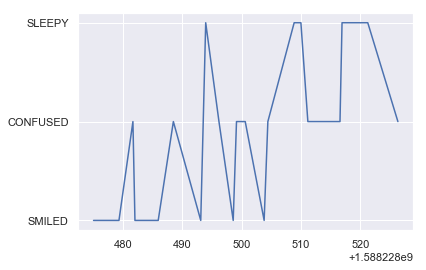

In [7]:
x = timestamp
y = emotions
plt.plot(x,y)